![display relevant image here](path/url/to/image)
- Banner/header image

# DataDriven Lending: Predicting Loan Approval with Machine Learning
- Relevant to Data and Business Context

## Overview
- BLUF (Bottom Line Up Front)
- One paragraph summary of final model performance and business implications
- Frame your 'story'

What's your final model and its performance?
What's the key business takeaway?
Why should stakeholders care about your results?

## Business Understanding

1. Begin by thoroughly analyzing the business context of FinTech Innovations' loan approval process. Write a short summary that:
- Describes the current manual process and its limitations
- Identifies key stakeholders and their needs
- Explains the implications of different types of model errors
- Justifies your choice between classification and regression approaches


**'The current loan approval process relies heavily on manual review by loan officers, leading to inconsistent decisions and slower response times to applicants.'** slow speed, increased labor hours, potential implicit bias / inconsistency

**Classification - determine if loan is approved or not
Regression - predict risk score**

2. Define your modeling goals and success criteria:
- Select appropriate evaluation metrics based on business impact
- You must use at least two different metrics
- Consider creating custom metric
- Establish baseline performance targets
- Document your reasoning for each choice

**
FP - approve a bad loan - borrower defaults = loss money
FN - denied good loan - loses interest revenue
Precision - what % are actually good of approved?
Recall - of all good loans, what % approved?
F1 score is a good balance of both
ROC-AUC - model's ability to distinguish between classes
baseline model - all deny could get ~76% accuracy or random 50/50**

## Data Understanding
3. Conduct comprehensive exploratory data analysis:
- Describe basic data characteristics

* 20,000 rows, 32 features, 2 possible targets (LoanApproved, RiskScore)
* duplicated rows (if any) removed
* float, int and object data types
* annualIncome as object (string)

- Examine distributions of all features and target variables
* target: 'LoanApproved' 0 (denied) 1 (approved)
* ~76% denied ~24% approved, majorly imbalanced
* will need to stratify split [ other ways?]
* distributions of credit score, income, loan amount, debt-to-income
* LoanAmount right-skewed, 

- Investigate relationships between features
- Create visualizations to help aid in EDA
- Document potential data quality issues and their implications

* missing values in 'EducationLevel', 'MaritalStatus', 'SavingsAccountBalance'. ~5 to 10%
* LoanAmount as object




4. Develop feature understanding:
- Categorize features by type (numerical, categorical, ordinal)
- Identify features requiring special preprocessing
- Document missing value patterns and their potential meanings
- Note potential feature engineering opportunities


Feature distributions:

Which features are skewed? Outliers?
Are there impossible values? (negative income, age > 120)
Which features have the most variability?
Do distributions differ between approved/denied loans?

Missing values (EducationLevel, MaritalStatus, SavingsAccountBalance):

Are they Missing Completely At Random (MCAR)?
Does approval rate differ when values are missing vs present?
Should you impute or create "unknown" categories?
Could missingness itself be informative?

Feature relationships:

Which features correlate strongly with LoanApproved?
Are there multicollinearity issues? (e.g., MonthlyIncome vs AnnualIncome)
Do you see threshold effects? (e.g., CreditScore > 700)
Are there feature interactions to engineer?

Visualizations needed:

Target distribution
Key features by approval status (split histograms)
Correlation heatmap
Approval rates by categorical features
Box plots for outliers

In [26]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform

df_loans = pd.read_csv('financial_loan_data.csv')
df_loans = df_loans.drop_duplicates() # check for unique

In [2]:
# EDA Code Here - Create New Cells As Needed
print(df_loans.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         20000 non-null  int64  
 1   AnnualIncome                20000 non-null  object 
 2   CreditScore                 20000 non-null  int64  
 3   EmploymentStatus            20000 non-null  object 
 4   EducationLevel              19099 non-null  object 
 5   Experience                  20000 non-null  int64  
 6   LoanAmount                  20000 non-null  int64  
 7   LoanDuration                20000 non-null  int64  
 8   MaritalStatus               18669 non-null  object 
 9   NumberOfDependents          20000 non-null  int64  
 10  HomeOwnershipStatus         20000 non-null  object 
 11  MonthlyDebtPayments         20000 non-null  int64  
 12  CreditCardUtilizationRate   20000 non-null  float64
 13  NumberOfOpenCreditLines     200

Column Descriptions
* ApplicationDate: Loan application date
* Age: Applicant's age
* AnnualIncome: Yearly income
* CreditScore: Creditworthiness score
* EmploymentStatus: Job situation
* EducationLevel: Highest education attained
* Experience: Work experience
* LoanAmount: Requested loan size
* LoanDuration: Loan repayment period
* MaritalStatus: Applicant's marital state
* NumberOfDependents: Number of dependents
* HomeOwnershipStatus: Homeownership type
* MonthlyDebtPayments: Monthly debt obligations
* CreditCardUtilizationRate: Credit card usage percentage
* NumberOfOpenCreditLines: Active credit lines
* NumberOfCreditInquiries: Credit checks count
* DebtToIncomeRatio: Debt to income proportion
* BankruptcyHistory: Bankruptcy records
* LoanPurpose: Reason for loan
* PreviousLoanDefaults: Prior loan defaults
* PaymentHistory: Past payment behavior
* LengthOfCreditHistory: Credit history duration
* SavingsAccountBalance: Savings account amount
* CheckingAccountBalance: Checking account funds
* TotalAssets: Total owned assets
* TotalLiabilities: Total owed debts
* MonthlyIncome: Income per month
* UtilityBillsPaymentHistory: Utility payment record
* JobTenure: Job duration
* NetWorth: Total financial worth
* BaseInterestRate: Starting interest rate
* InterestRate: Applied interest rate
* MonthlyLoanPayment: Monthly loan payment
* TotalDebtToIncomeRatio: Total debt against income
* LoanApproved: Loan approval status - binary 0, 1
* RiskScore: Risk assessment score - likelihood of loan default or financial instability

In [3]:
# check for missing values
missing_values = df_loans.isna().sum()
print(missing_values)

# proportion of values in target
class_dist = df_loans['LoanApproved'].value_counts(normalize=True)
print('\nDistribution of Class')
print(class_dist)

Age                              0
AnnualIncome                     0
CreditScore                      0
EmploymentStatus                 0
EducationLevel                 901
Experience                       0
LoanAmount                       0
LoanDuration                     0
MaritalStatus                 1331
NumberOfDependents               0
HomeOwnershipStatus              0
MonthlyDebtPayments              0
CreditCardUtilizationRate        0
NumberOfOpenCreditLines          0
NumberOfCreditInquiries          0
DebtToIncomeRatio                0
BankruptcyHistory                0
LoanPurpose                      0
PreviousLoanDefaults             0
PaymentHistory                   0
LengthOfCreditHistory            0
SavingsAccountBalance          572
CheckingAccountBalance           0
TotalAssets                      0
TotalLiabilities                 0
MonthlyIncome                    0
UtilityBillsPaymentHistory       0
JobTenure                        0
NetWorth            

In [4]:
# check for impossible values: age, credit score range

print(f"\nAge range: {df_loans['Age'].min()} to {df_loans['Age'].max()}")
if df_loans['Age'].min() < 18 or df_loans['Age'].max() > 100:
    print(" Invalid age values")

# Credit score checks
print(f"CreditScore range: {df_loans['CreditScore'].min()} to {df_loans['CreditScore'].max()}")
if df_loans['CreditScore'].min() < 300 or df_loans['CreditScore'].max() > 850:
    print("Credit scores outside typical 300-850 range")



Age range: 18 to 80
CreditScore range: 343 to 712


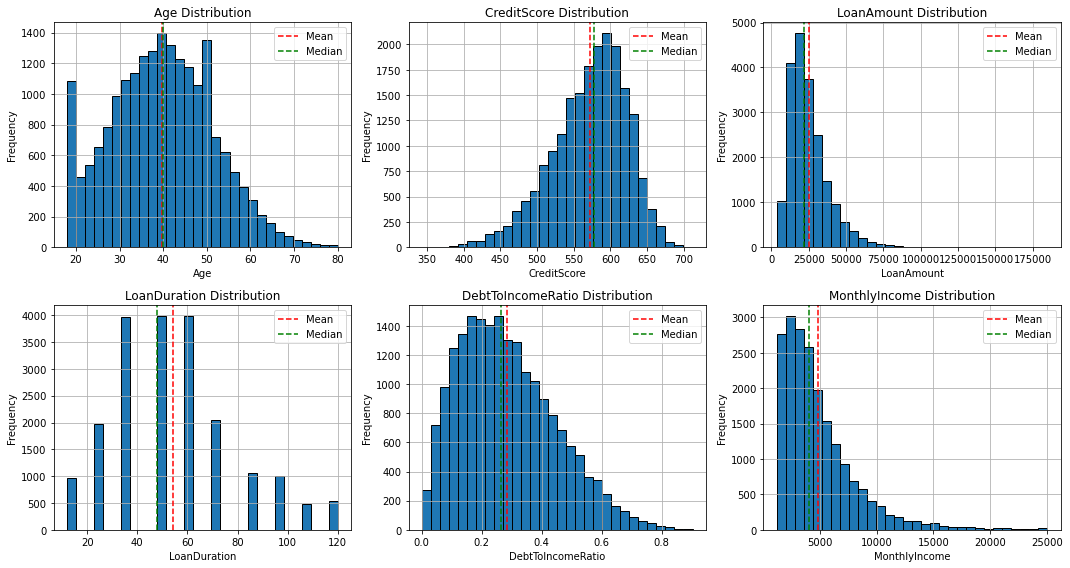

In [5]:
# numeric_features = df_loans.select_dtypes(include=['int64', 'float64']).columns

# Visualize distributions of key features
key_numeric = ['Age', 'CreditScore', 'LoanAmount', 'LoanDuration', 
               'DebtToIncomeRatio', 'MonthlyIncome']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(key_numeric):
    df_loans[col].hist(bins=30, ax=axes[idx], edgecolor='black')
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    
    # Add mean and median lines
    axes[idx].axvline(df_loans[col].mean(), color='red', linestyle='--', label='Mean')
    axes[idx].axvline(df_loans[col].median(), color='green', linestyle='--', label='Median')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# print("\nSkewness of numeric features:")
# skewness = df_loans[numeric_features].skew().sort_values(ascending=False)
# print(skewness[abs(skewness) > 1])  # Show highly skewed features

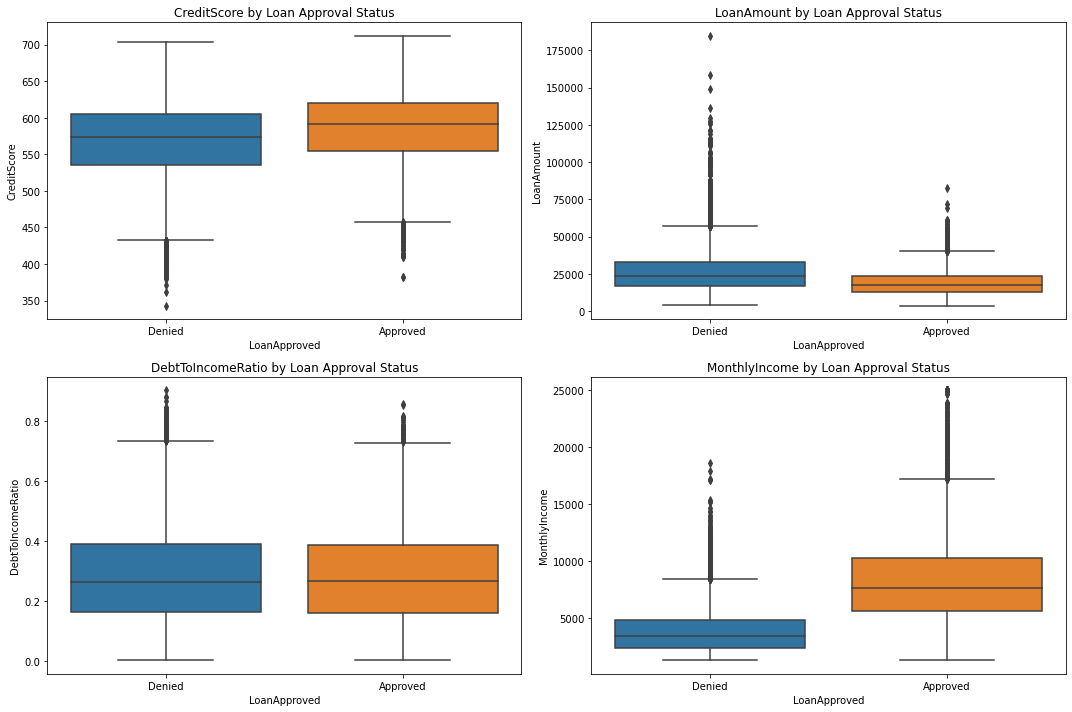

In [6]:
# Numeric features by approval status
key_features = ['CreditScore', 'LoanAmount', 'DebtToIncomeRatio', 'MonthlyIncome']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    sns.boxplot(data=df_loans, x='LoanApproved', y=feature, ax=axes[idx])
    axes[idx].set_title(f'{feature} by Loan Approval Status')
    axes[idx].set_xticklabels(['Denied', 'Approved'])

plt.tight_layout()
plt.show()

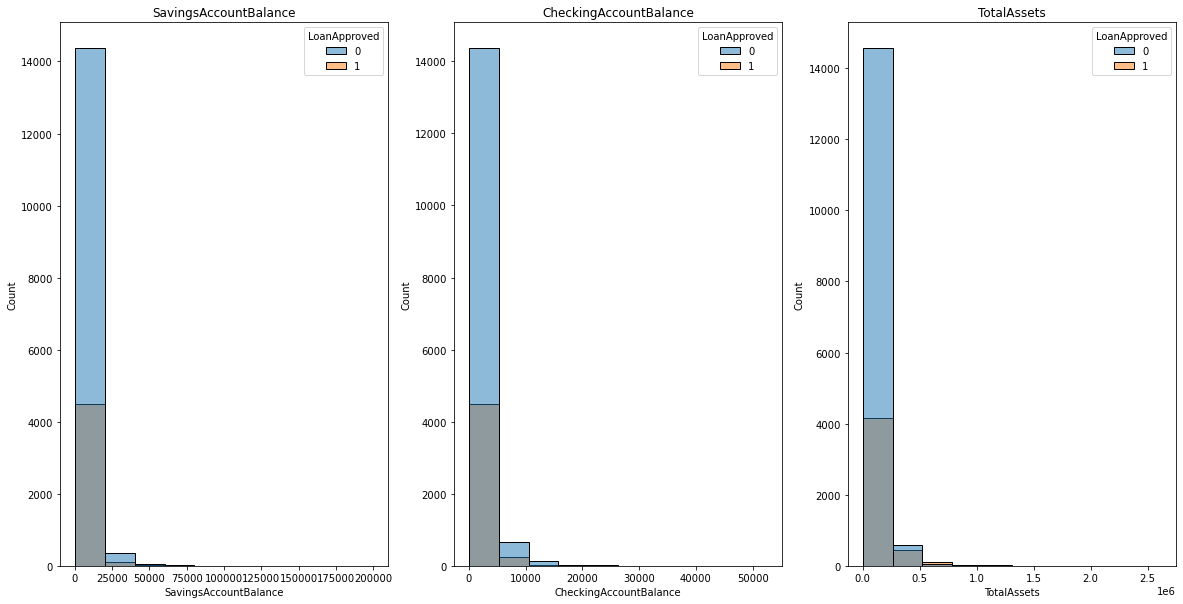

In [7]:
# distribution of savingsAccountBalance, CheckingAccountBalance, TotalAssets
plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
savings_hist = sns.histplot(data=df_loans, x='SavingsAccountBalance', hue='LoanApproved',bins=10)
plt.title('SavingsAccountBalance')

plt.subplot(1, 3, 2)
savings_hist = sns.histplot(data=df_loans, x='CheckingAccountBalance', hue='LoanApproved',bins=10)
plt.title('CheckingAccountBalance')

plt.subplot(1, 3, 3)
savings_hist = sns.histplot(data=df_loans, x='TotalAssets', hue='LoanApproved',bins=10)
plt.title('TotalAssets')

plt.show()

# all show right-skewed distributions. Logistic Regression will need transformation but we're using RF or XGBoost

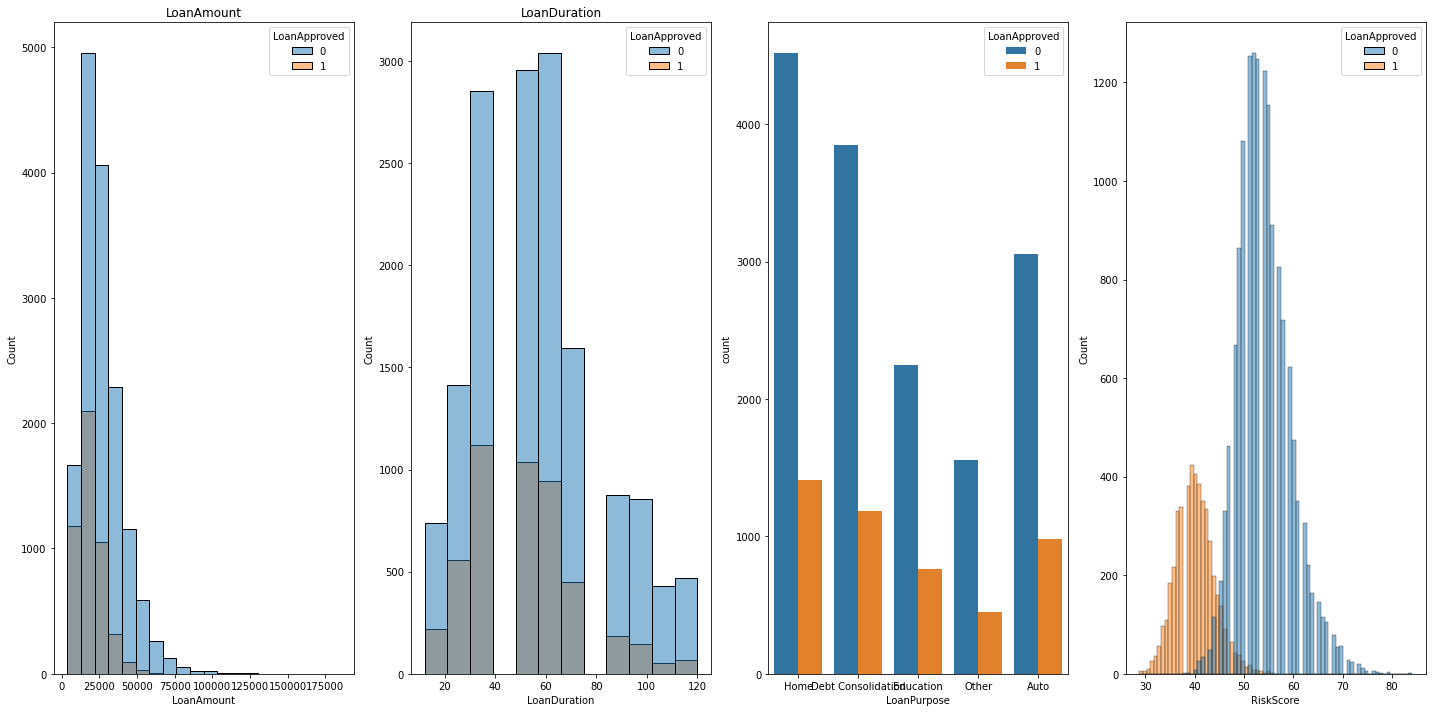

In [8]:
# distributions of loan amount, loan duration, loan purpose
plt.figure(figsize=(20,10))
plt.subplot(1, 4, 1)
amount_hist = sns.histplot(data=df_loans, x='LoanAmount', hue='LoanApproved',bins=20)
plt.title('LoanAmount')

plt.subplot(1, 4, 2)
duration_hist = sns.histplot(data=df_loans, x='LoanDuration',hue='LoanApproved', bins=12)
plt.title('LoanDuration')

plt.subplot(1, 4, 3)
purpose_counts = df_loans['LoanPurpose'].value_counts(normalize=True)
# purpose_hist = sns.barplot(x=purpose_counts.index, y=purpose_counts.values)
sns.countplot(data=df_loans, x='LoanPurpose', hue='LoanApproved')

plt.subplot(1, 4, 4)
risk_hist = sns.histplot(data=df_loans, x='RiskScore', hue='LoanApproved')

plt.tight_layout()
plt.show()

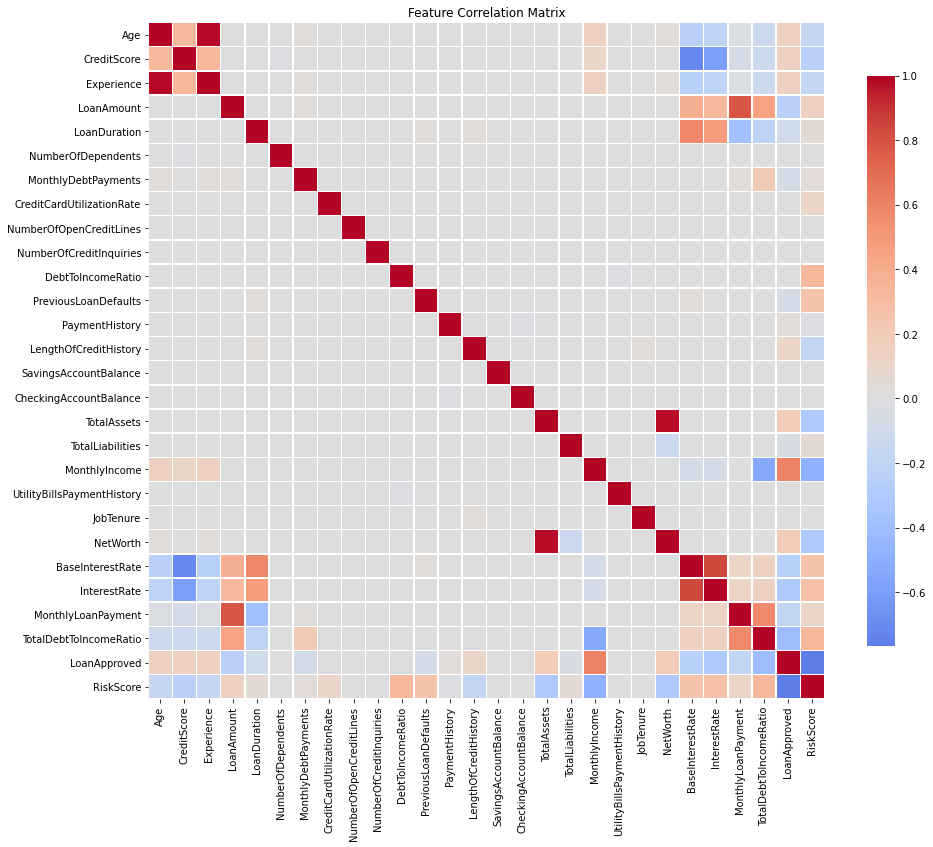


Strongest correlations with LoanApproved:
MonthlyIncome                 0.604101
NetWorth                      0.187892
TotalAssets                   0.184011
CreditScore                   0.142000
Age                           0.141029
Experience                    0.140755
LengthOfCreditHistory         0.105949
PaymentHistory                0.030804
JobTenure                     0.004997
UtilityBillsPaymentHistory    0.003303
NumberOfDependents            0.001717
CheckingAccountBalance        0.000660
DebtToIncomeRatio             0.000034
SavingsAccountBalance        -0.000258
NumberOfOpenCreditLines      -0.004769
NumberOfCreditInquiries      -0.005885
CreditCardUtilizationRate    -0.010466
TotalLiabilities             -0.029434
PreviousLoanDefaults         -0.065343
MonthlyDebtPayments          -0.070415
LoanDuration                 -0.094558
MonthlyLoanPayment           -0.184272
LoanAmount                   -0.239496
BaseInterestRate             -0.247263
InterestRate         

In [9]:
# Correlation matrix for numeric features
numeric_data = df_loans.select_dtypes(include=['int64', 'float64'])

# Calculate correlation
corr_matrix = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Show strongest correlations with target
print("\nStrongest correlations with LoanApproved:")
target_corr = corr_matrix['LoanApproved'].sort_values(ascending=False)
print(target_corr[target_corr.index != 'LoanApproved'])

# Check for multicollinearity
print("High correlations (potential multicollinearity):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                            corr_matrix.iloc[i, j]))

if high_corr:
    for feat1, feat2, corr_val in high_corr:
        print(f"  - {feat1} <-> {feat2}: {corr_val:.3f}")
else:
    print("No severe multicollinearity detected (|r| > 0.8)")

Calculate and plot approval rates by category (not just counts)
Check the exact class ratio: df_loans['LoanApproved'].value_counts()
For continuous variables, compare means/medians by approval status
Consider if this imbalance reflects reality or is a data collection issue

## Data Preparation
5. Design your preprocessing strategy:
- DONE Create separate preprocessing flows for different feature types
- DONE Must utilize ColumnTransformer and Pipeline
- Consider using FeatureUnion as well
- DONE Handle missing values appropriately for each feature
median for numeric, mode for categorical

- Handle Categorical and Ordinal data appropriately
- DONE Scale numeric values if model requires it (linear model)
StandardScaler or minMaxScaler
- Document your reasoning for each preprocessing decision
1. Data Cleaning
2. Split Data
3. Identify Feature Types
4. Create Preprocessing Components
5. Create Preprocessor 
6. Build Model Pipelines

**Stage 1: Data Type Correction (Pre-Pipeline)**
- Fixed AnnualIncome from object to numeric using `pd.to_numeric()`
- Rationale: Ensures accurate feature type detection and proper preprocessing

**Stage 2: Preprocessing Pipeline**
Our preprocessing strategy uses nested pipelines:
- **numeric_transformer**: Median imputation → StandardScaler
- **categorical_transformer**: Mode imputation → OneHotEncoder
- **preprocessor**: ColumnTransformer applying appropriate transformer to each feature type

**Stage 3: Model Pipeline**
- Combines preprocessor with classifier
- Ensures no data leakage (preprocessing fit only on training data)

In [15]:
# 1. Data Cleaning
# change 'AnnualIncome' datatype
if df_loans['AnnualIncome'].dtype !='float64':
    df_loans['AnnualIncome'] = df_loans['AnnualIncome'].str.replace(r'[$,]','', regex=True).astype(float)

# 2. Split Data
X = df_loans.drop(columns=['LoanApproved','RiskScore'])
y = df_loans['LoanApproved']

# 3. Identify Feature Types

# define feature groups as lists
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Class distribution in training set:")
print(y_train.value_counts(normalize=True))

Training set size: 16000
Test set size: 4000
Class distribution in training set:
0    0.761
1    0.239
Name: LoanApproved, dtype: float64


In [16]:

# 4. Create Preprocessing Components for numeric / categorical

# Create transformer for numerical features
# Create a pipeline with imputation and standard scaling
# Fill null values with mean
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create transformer for categorical features
# Create a pipeline with imputation and onehotencoding
# Fill null values with most common
categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(handle_unknown='ignore'))
])

# 5. Create Preprocessor
# Use ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [17]:
# 6. Build Model Pipelines
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=20, random_state=42))
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42))
])

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
])

ada_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
])

class_ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=class_ratio, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, eval_metric='logloss'))
])

In [18]:
def business_cost_score(y_true, y_pred):
    """
    Calculate total business cost.
    FP (approve bad loan): $50,000 loss
    FN (reject good customer): $8,000 lost profit
    
    Returns negative cost (GridSearch maximizes, we minimize cost)
    """
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    total_cost = (FP * 50000) + (FN * 8000)
    
    return -total_cost  # Negative because GridSearch maximizes

# Create the scorer
business_scorer = make_scorer(business_cost_score)

# Also create F-beta scorer as alternative
from sklearn.metrics import fbeta_score
beta = np.sqrt(8000 / 50000)  # 0.4 - weights precision higher
fbeta_scorer = make_scorer(fbeta_score, beta=beta)

# 7. Define Parameter Grids for models
# Define parameter grid for Random Forest

rf_param_grid = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [10, 15, 20],
    'classifier__min_samples_split': [5, 10, 20],   # Higher for precision
    'classifier__min_samples_leaf': [2, 5, 10],     # Higher for precision
    'classifier__max_features': ['sqrt', 0.8]
}

# Define parameter grid for gradient boost
gb_param_grid = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__min_child_weight': [5, 10, 15],    # Higher = more conservative
    'classifier__gamma': [0.1, 0.2, 0.3],           # Minimum loss reduction
    'classifier__subsample': [0.8, 0.9],
    'classifier__colsample_bytree': [0.8, 0.9],
    'classifier__reg_alpha': [0.1, 0.5],            # L1 regularization
    'classifier__reg_lambda': [1, 2],               # L2 regularization
    'classifier__scale_pos_weight': [class_ratio, class_ratio*1.5, class_ratio*2]
}

# Define parameter grid for Adaboost
ada_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.5, 1.0],
    'classifier__algorithm': ['SAMME.R']
}


# Define parameter grid for XGBoost
xgb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__min_child_weight': [1, 3, 5],  # NOT min_samples_leaf!
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

In [21]:
models = {
    'Decision Tree': dt_pipeline,
    'Random Forest': rf_pipeline,
    'Gradient Boosting': gb_pipeline,
    'AdaBoost': ada_pipeline,
    'XGBoost': xgb_pipeline
}

results = []

for model_name, pipeline in models.items():
    print(f"\nTraining {model_name}...")
    
    # Fit with default params
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate business cost
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cost_FP = fp * 50000
    cost_FN = fn * 8000
    total_cost = cost_FP + cost_FN
    
    # Evaluate
    results.append({
        'Model': model_name,
        'F1-Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'Business_Cost': total_cost
    })
    
    print(f"  F1-Score: {results[-1]['F1-Score']:.3f}")
    print(f"  ROC-AUC: {results[-1]['ROC-AUC']:.3f}")
    print(f"  Business Cost: ${results[-1]['Business_Cost']:,.0f}")

# Display results
results_df = pd.DataFrame(results).sort_values('Business_Cost', ascending=True)
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
print(f"Best performing model: {best_model_name}")
print(f"Business Cost: ${results_df.iloc[0]['Business_Cost']:,.0f}") 


Training Decision Tree...
  F1-Score: 0.786
  ROC-AUC: 0.913
  Business Cost: $16,504,000

Training Random Forest...
  F1-Score: 0.846
  ROC-AUC: 0.979
  Business Cost: $5,350,000

Training Gradient Boosting...
  F1-Score: 0.898
  ROC-AUC: 0.989
  Business Cost: $4,804,000

Training AdaBoost...
  F1-Score: 0.801
  ROC-AUC: 0.970
  Business Cost: $7,000,000

Training XGBoost...
  F1-Score: 0.869
  ROC-AUC: 0.987
  Business Cost: $12,070,000

MODEL COMPARISON RESULTS
             Model  F1-Score  Precision    Recall   ROC-AUC  Business_Cost
 Gradient Boosting  0.898242   0.915309  0.881799  0.988741        4804000
     Random Forest  0.846111   0.909747  0.790795  0.979196        5350000
          AdaBoost  0.801362   0.875931  0.738494  0.969780        7000000
           XGBoost  0.869483   0.795830  0.958159  0.987256       12070000
     Decision Tree  0.785783   0.726465  0.855649  0.912798       16504000
\Best performing model: Gradient Boosting
Business Cost: $4,804,000


In [29]:
# 8. Perform random search then fine tune with grid

# gb tuning - randomized search

def business_cost_score(y_true, y_pred):
    """
    FP (approve bad loan): $50,000 loss
    FN (reject good customer): $8,000 lost profit
    Returns negative cost (GridSearch maximizes, we minimize cost)
    """
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    total_cost = (FP * 50000) + (FN * 8000)
    return -total_cost  # Negative because GridSearch maximizes

business_scorer = make_scorer(business_cost_score)

scoring = {
    'business_cost': business_scorer,
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

gb_param_grid = {
        'classifier__n_estimators': randint(150, 400),
        'classifier__learning_rate': uniform(0.03, 0.17),  # 0.03 to 0.20
        'classifier__max_depth': randint(3, 6),
        'classifier__min_samples_split': randint(10, 31),
        'classifier__min_samples_leaf': randint(5, 16),
        'classifier__subsample': uniform(0.7, 0.3)  # 0.7 to 1.0
    }

gb_random_search = RandomizedSearchCV(
    gb_pipeline,
    gb_param_grid,
    n_iter=30,
    cv=5,
    scoring=scoring,
    refit='business_cost',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

gb_random_search.fit(X_train, y_train)

# Print CV results
best_idx = gb_random_search.best_index_
cv_results = gb_random_search.cv_results_

print(f"\n Tuning complete!")
print(f"\nGB Best Parameters:")
for param, value in gb_random_search.best_params_.items():
    print(f"  {param.replace('classifier__', '')}: {value}")


    print(f"\nCross-Validation Performance (5-fold):")
print(f"  Business Cost: ${-cv_results['mean_test_business_cost'][best_idx]:,.0f} ± ${cv_results['std_test_business_cost'][best_idx]:,.0f}")
print(f"  Precision:     {cv_results['mean_test_precision'][best_idx]:.3f} ± {cv_results['std_test_precision'][best_idx]:.3f}")
print(f"  Recall:        {cv_results['mean_test_recall'][best_idx]:.3f} ± {cv_results['std_test_recall'][best_idx]:.3f}")
print(f"  F1:            {cv_results['mean_test_f1'][best_idx]:.3f} ± {cv_results['std_test_f1'][best_idx]:.3f}")
print(f"  ROC-AUC:       {cv_results['mean_test_roc_auc'][best_idx]:.3f} ± {cv_results['std_test_roc_auc'][best_idx]:.3f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 22.7min finished



 Tuning complete!

Best Parameters:
  learning_rate: 0.15393121856696784

Cross-Validation Performance (5-fold):
  max_depth: 3

Cross-Validation Performance (5-fold):
  min_samples_leaf: 15

Cross-Validation Performance (5-fold):
  min_samples_split: 14

Cross-Validation Performance (5-fold):
  n_estimators: 383

Cross-Validation Performance (5-fold):
  subsample: 0.8075397185632818

Cross-Validation Performance (5-fold):
  Business Cost: $3,423,600 ± $512,469
  Precision:     0.924 ± 0.012
  Recall:        0.903 ± 0.005
  F1:            0.914 ± 0.008
  ROC-AUC:       0.992 ± 0.001


In [30]:
# Adaboost tuning - randomized search

def business_cost_score(y_true, y_pred):
    """
    FP (approve bad loan): $50,000 loss
    FN (reject good customer): $8,000 lost profit
    Returns negative cost (GridSearch maximizes, we minimize cost)
    """
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    total_cost = (FP * 50000) + (FN * 8000)
    return -total_cost  # Negative because GridSearch maximizes

business_scorer = make_scorer(business_cost_score)

scoring = {
    'business_cost': business_scorer,
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

ada_param_grid = {
        'classifier__n_estimators': randint(80, 300),
        'classifier__learning_rate': uniform(0.3, 1.2)  # 0.3 to 1.5
}

ada_random_search = RandomizedSearchCV(
    ada_pipeline,
    ada_param_grid,
    n_iter=30,
    cv=5,
    scoring=scoring,
    refit='business_cost',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

ada_random_search.fit(X_train, y_train)

# Print CV results
best_idx = ada_random_search.best_index_
cv_results = ada_random_search.cv_results_

print(f"\nTuning complete!")
print(f"\nAdaboost Best Parameters:")
for param, value in ada_random_search.best_params_.items():
    print(f"  {param.replace('classifier__', '')}: {value}")

print(f"\nCross-Validation Performance (5-fold):")
print(f"  Business Cost: ${-cv_results['mean_test_business_cost'][best_idx]:,.0f} ± ${cv_results['std_test_business_cost'][best_idx]:,.0f}")
print(f"  Precision:     {cv_results['mean_test_precision'][best_idx]:.3f} ± {cv_results['std_test_precision'][best_idx]:.3f}")
print(f"  Recall:        {cv_results['mean_test_recall'][best_idx]:.3f} ± {cv_results['std_test_recall'][best_idx]:.3f}")
print(f"  F1:            {cv_results['mean_test_f1'][best_idx]:.3f} ± {cv_results['std_test_f1'][best_idx]:.3f}")
print(f"  ROC-AUC:       {cv_results['mean_test_roc_auc'][best_idx]:.3f} ± {cv_results['std_test_roc_auc'][best_idx]:.3f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.1min finished



Tuning complete!

Best Parameters:
  learning_rate: 0.3780619115823354
  n_estimators: 211

Cross-Validation Performance (5-fold):
  Business Cost: $3,121,600 ± $196,523
  Precision:     0.934 ± 0.005
  Recall:        0.882 ± 0.009
  F1:            0.907 ± 0.006
  ROC-AUC:       0.992 ± 0.001


In [33]:
# RF tuning

def business_cost_score(y_true, y_pred):
    """
    FP (approve bad loan): $50,000 loss
    FN (reject good customer): $8,000 lost profit
    Returns negative cost (GridSearch maximizes, we minimize cost)
    """
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    total_cost = (FP * 50000) + (FN * 8000)
    return -total_cost  # Negative because GridSearch maximizes

business_scorer = make_scorer(business_cost_score)

scoring = {
    'business_cost': business_scorer,
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

rf_param_grid = {
        'classifier__n_estimators': [200, 300],
        'classifier__max_depth': [10, 15, 20],
        'classifier__min_samples_split': [5, 10],
        'classifier__min_samples_leaf': [2, 5],
        'classifier__max_features': ['sqrt', 0.8]
    }

rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    rf_param_grid,
    n_iter=30,
    cv=5,
    scoring=scoring,
    refit='business_cost',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_random_search.fit(X_train, y_train)

# Print CV results
best_idx = rf_random_search.best_index_
cv_results = rf_random_search.cv_results_

print(f"\nTuning complete!")
print(f"\Random Forest Best Parameters:")
for param, value in rf_random_search.best_params_.items():
    print(f"  {param.replace('classifier__', '')}: {value}")

print(f"\nCross-Validation Performance (5-fold):")
print(f"  Business Cost: ${-cv_results['mean_test_business_cost'][best_idx]:,.0f} ± ${cv_results['std_test_business_cost'][best_idx]:,.0f}")
print(f"  Precision:     {cv_results['mean_test_precision'][best_idx]:.3f} ± {cv_results['std_test_precision'][best_idx]:.3f}")
print(f"  Recall:        {cv_results['mean_test_recall'][best_idx]:.3f} ± {cv_results['std_test_recall'][best_idx]:.3f}")
print(f"  F1:            {cv_results['mean_test_f1'][best_idx]:.3f} ± {cv_results['std_test_f1'][best_idx]:.3f}")
print(f"  ROC-AUC:       {cv_results['mean_test_roc_auc'][best_idx]:.3f} ± {cv_results['std_test_roc_auc'][best_idx]:.3f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 20.1min finished



Tuning complete!
\Random Forest Best Parameters:
  n_estimators: 300
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: sqrt
  max_depth: 20

Cross-Validation Performance (5-fold):
  Business Cost: $6,272,800 ± $516,244
  Precision:     0.859 ± 0.012
  Recall:        0.834 ± 0.007
  F1:            0.846 ± 0.009
  ROC-AUC:       0.977 ± 0.002


In [ ]:
# Compare models
rf_best_cvscore = rf_grid_search.best_score_
ada_best_cvscore = ada_grid_search.best_score_
xgb_best_cvscore = xgb_grid_search.best_score_

## Modeling
6. Implement your modeling approach:
- Choose appropriate model algorithms based on your problem definition
- Set up validation strategy with chosen metrics
- Use a train test split and cross validation
- DONE Create complete pipeline including any preprocessing and model
- Document your reasoning for each modeling decision

7. Optimize your model:
- Define parameter grid based on your understanding of the algorithms
- Implement GridSearchCV and/or RandomizedSearchCV with chosen metrics
- Consider tuning preprocessing steps
- Track and document the impact of different parameter combinations
- Consider the trade-offs between different model configurations

NOTE: Be mindful of time considerations - showcase “how to tune” 


In [ ]:
#  Modeling Code Here - Create New Cells as Needed


## Evaluation and Conclusion
8. Conduct thorough evaluation of final model:
- Assess models test data performance using your defined metrics
- Analyze performance across different data segments
- Identify potential biases or limitations
- Visualize model performance
    - Classification: Confusion Matrix/ROC-AUC
    - Regression: Scatter Plot (Predicted vs. Actual values)

9. Extract and interpret feature importance/significance:
- Which features had the most impact on your model?
- Does this lead to any potential business recommendations?

10. Prepare your final deliverable:
- Technical notebook with complete analysis
- Executive summary for business stakeholders
- Recommendations for implementation
- Documentation of potential improvements